# Spencer Hallyburton
# AM 207 Pset 2

## Collaborator: Salvador Barragan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi as PI
import sympy as sym
import scipy
import scipy.integrate as integrate
from scipy.stats import truncnorm

DEC = 3

font_val = 18
plt.rc('font', size=font_val)          # controls default text sizes
plt.rc('axes', titlesize=font_val)
plt.rc('axes', labelsize=font_val)    # fontsize of the x and y labels
plt.rc('legend', fontsize=(font_val-3))    # legend fontsize
plt.rc('font', family='Sans Serif')


In [2]:
Nsamp = 1000
Ntrials = 1000

## Problem 1: Monte Carlo Integration

For the Monte Carlo integration problem, we have a PDF over X and we want to comput the expectation of some score function, h(X) over this set of X. The first step in this process is to output the distributions of these two parameters. Since f(X) is a PDF, we can comput the cumulative density function, CDF.

Using the law of large numbers, we know that $\mathbb{E}[h(X)]$ approaches the mean of h(X) as the number of samples approaches infinity. Using this fact, we can compute $\mathbb{E}[h(X)]$ by taking samples over the distribution of X and calculating the mean of the output. 

0.001
X Area: 1.00
H Area: 0.56


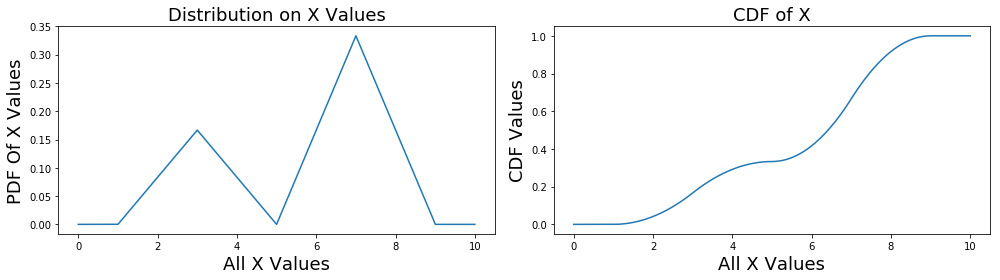

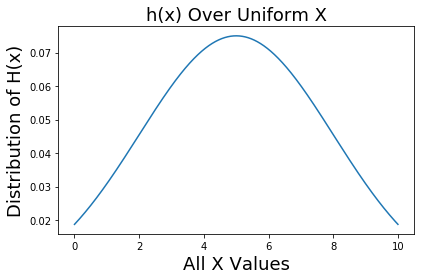

In [3]:
# Describe the distribution on X:
dx = 1 * (10**-DEC)
print(dx)

x = np.arange(0, 10, dx)
x_out = np.piecewise(x, [(x>=1) * (x<=3), (x>3) * (x<=5), (x>5) * (x<=7), (x>7) * (x<=9)], 
                [lambda x: 1/12*(x-1), lambda x: -1/12*(x-5), lambda x: 1/6*(x-5), lambda x: -1/6*(x-9)])

# Define function, h(X)
h = lambda x: 1/(3*np.sqrt(2)*PI) * np.exp(-1/18 * (x-5)**2)

# Check normalization condition on both:
area_X = np.trapz(x_out, x=x)
print('X Area: %.2f' % area_X)
area_H = integrate.quad(h, -1*np.inf, np.inf)
print('H Area: %.2f' % area_H[0])

# Plotting outputs
fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(x, x_out)
ax[0].set_title('Distribution on X Values')
ax[0].set_xlabel('All X Values')
ax[0].set_ylabel('PDF Of X Values')
CDF_X = np.cumsum(dx*x_out)
ax[1].plot(x, CDF_X)
ax[1].set_title('CDF of X')
ax[1].set_xlabel('All X Values')
ax[1].set_ylabel('CDF Values')
plt.tight_layout()
plt.show()

# Plot h(x)
fig, ax = plt.subplots()
ax.plot(x, h(x))
ax.set_title('h(x) Over Uniform X')
ax.set_xlabel('All X Values')
ax.set_ylabel('Distribution of H(x)')
plt.tight_layout()
plt.show()

### Method 1: Inverse Transform Sampling

The first sampling method we can use is to sample from the CDF of $f(\text{X})$. We do so by sampling along the y value of the CDF of $f(\text{X})$ and mapping this back to an input, x. We then use this x to calculate values of $h(\text{x})$ under the procedure that more probable values of x are selected using the inverse sampling method on the CDF.

In [4]:
##################################################################
# Define a function for inverse sampling
def Perform_Inverse(Nsamp, x, x_out, CDF_X):
    # Sample uniformly from CDF of X
    y_rand = np.random.rand(Nsamp)
    y_rand = np.round(y_rand, decimals=DEC)
    CDF_X = np.round(CDF_X, decimals=DEC)

    # Map the y value back to X on the CDF:
    locs = []
    for yval in y_rand:
        A = np.argmax(CDF_X==yval)
        locs.append(A)

    # Get the mean value:
    h_exp_1 = np.mean(h(x[locs]))

    return(h_exp_1, locs)
##################################################################

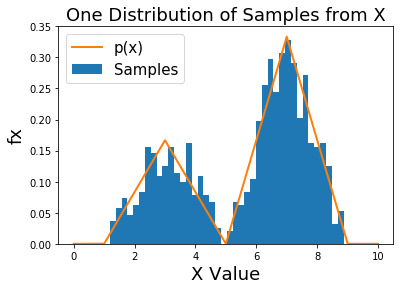

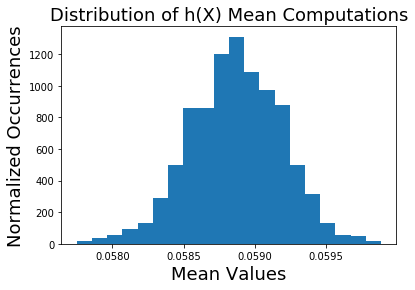

Expectation: E[h(X)] = 0.05887


In [5]:
# Evaluate the inverse sampling function
_, locs = Perform_Inverse(Nsamp, x, x_out, CDF_X)

h_out_1 = np.zeros(Ntrials)
for m in range(Ntrials):
    h_out_1[m], _ = Perform_Inverse(Nsamp, x, x_out, CDF_X)

# Plot the histogram:
plt.hist(x[locs], bins=40, normed=True,label=u'Samples')
plt.plot(x, x_out, linewidth=2, label=u'p(x)')
plt.title('One Distribution of Samples from X')
plt.xlabel('X Value')
plt.ylabel('fx')
plt.legend()
plt.show()

# Plot the histogram of mean values:
plt.hist(h_out_1, bins=20, normed=True)
plt.title('Distribution of h(X) Mean Computations')
plt.ylabel('Normalized Occurrences')
plt.xlabel('Mean Values')
plt.show()

# Compute expectation of this:
print('Expectation: E[h(X)] = %.5f' % np.mean(h_out_1))

### Method 2: Rejection Sampling

The second method of sampling is rejection sampling. We select X values from a proposal distribution and perform and accept/reject criteria on the ensuing selection y points compared to the pdf, f(x). From the selection of points, we determine the support of our distribution and then subsequently multiply the fraction of points meeting our criteria with our support, then use the values obtained to compute an h(x) expectation estimate.

#### a) Uniform Proposal Distribution

This first proposal distribution is a uniform distribution over X values.

In [6]:
##################################################################
# Define a function for rejection sampling
def Perform_Rejection_Uniform(Nsamp, x, x_out):
    accepted = 0
    samples = np.zeros(Nsamp)
    count = 0
    xmin = 1
    xmax = 9
    ymax = max(x_out)
    
    # Loop over to draw samples
    while (accepted < Nsamp):
        # Step 1: Draw uniform x from min to max
        xrand = np.round(np.random.uniform(xmin, xmax), decimals=DEC)

        # Step 2: Pick uniform on [0, ymax)
        yrand = np.random.uniform(0, ymax)

        # Step 3: Do the accept/reject comparison
        if yrand < x_out[np.where(x == xrand)]:
            samples[accepted] = xrand
            accepted += 1
        count += 1

    return(samples, count, accepted)
##################################################################

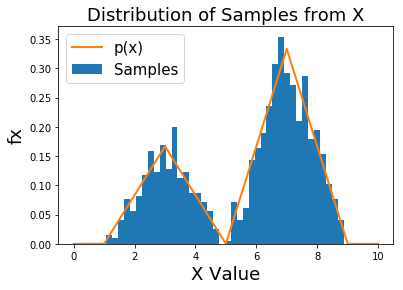

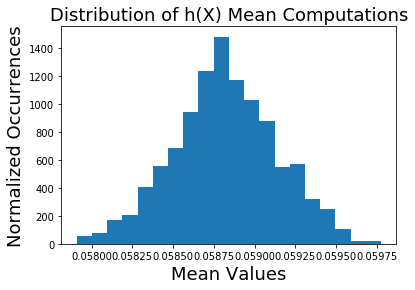

Count: 3121070 Accepted: 1000000
Percent Accept: 0.320
Expectation: E[h(X)] = 0.05882


In [7]:
# Evaluate the rejection sampling
samples2, count2, accepted2 = Perform_Rejection_Uniform(Nsamp, x, x_out)

# Plot the histogram:
plt.hist(samples2, bins=40, normed=True, label=u'Samples')
plt.plot(x, x_out, linewidth=2, label=u'p(x)')
plt.title('Distribution of Samples from X')
plt.xlabel('X Value')
plt.ylabel('fx')
plt.legend()
plt.show()


# Evaluation the Rejection Sampling many times
h_out_2 = np.zeros(Ntrials)
count2_all = 0
accept2_all = 0
for m in range(Ntrials):
    samples2_all, count, accept = Perform_Rejection_Uniform(Nsamp, x, x_out)
    count2_all += count
    accept2_all += accept
    h_out_2[m] = np.mean(h(samples2_all))
    
# Plot the histogram of mean values:
plt.hist(h_out_2, bins=20, normed=True)
plt.title('Distribution of h(X) Mean Computations')
plt.ylabel('Normalized Occurrences')
plt.xlabel('Mean Values')
plt.show()

print("Count:",count2_all, "Accepted:", accept2_all)
print('Percent Accept: %.3f' % (accept2_all/count2_all))
print('Expectation: E[h(X)] = %.5f' % np.mean(h_out_2))

#### b) Normal Proposal Distribution (Steroids)

The second proposal distribution is over a normal distribution that encapsulates the PDF values in f(x).

In [8]:
# Create a proposal pdf: Normal Distribution
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*PI)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

mu_1 = 6
sigma_1 = 3
Mg = lambda x: 2.8*gaussian(x, mu_1, sigma_1)
invCDFg = lambda x: dx*np.sum(Mg(np.arange(1-dx, x, dx))) # generates our proposal using inverse sampling
CDFvals = np.round( list(map(lambda val: invCDFg(val), x)), decimals= DEC)

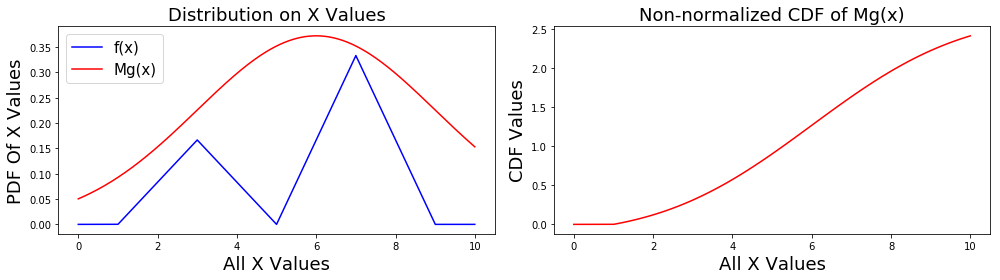

Inverse Sampling Range: (0.00019, 2.22198)


In [9]:
# domain limits
xmin = 1 # the lower limit of our domain
xmax = 9 # the upper limit of our domain

# Show proposal overlayed on Normal distribution
# Plotting outputs
fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(x, x_out,'b', label=u'f(x)')
ax[0].plot(x, Mg(x),'r', label=u'Mg(x)')
ax[0].set_title('Distribution on X Values')
ax[0].set_xlabel('All X Values')
ax[0].set_ylabel('PDF Of X Values')
ax[0].legend()
ax[1].plot(x, CDFvals, 'r')
ax[1].set_title('Non-normalized CDF of Mg(x)')
ax[1].set_xlabel('All X Values')
ax[1].set_ylabel('CDF Values')
plt.tight_layout()
plt.show()

# range limits for inverse sampling
umin = invCDFg(xmin)
umax = invCDFg(xmax)
print('Inverse Sampling Range: (%.5f, %.5f)' % (umin, umax))


In [10]:
##################################################################
# Define a function for rejection sampling on steroids
def Perform_Rejection_Steroids(Nsamp, x, x_out, Mg, lower, upper, mu, sigma):
    accepted = 0
    samples = np.zeros(Nsamp)
    count = 0
    
    # Sample from normal:
    X = truncnorm( (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma  )
    Xvals = np.round( X.rvs(4*Nsamp), decimals = DEC)
    
    # Generation Loop
    while (accepted < Nsamp):
        # Get a proposal X value from truncated normal
        xproposal = Xvals[count]
        
        # Pick a uniform number on [0, 1)
        y = np.random.uniform(0,1)

        # Do the accept/reject comparison
        p = x_out[np.argmax(x==xproposal)]
        if y < p / Mg(xproposal):
            samples[accepted] = xproposal
            accepted+=1
        count += 1

    return(samples, count, accepted)
##################################################################

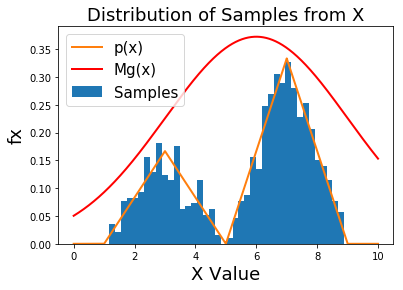

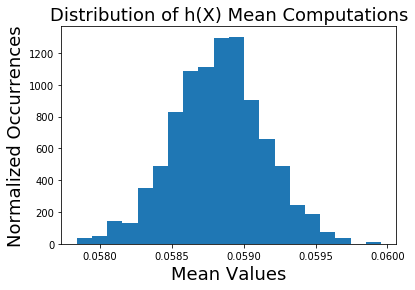

Count: 2606661 Accepted: 1000000
Percent Accept: 0.384
Expectation: E[h(X)] = 0.05882


In [11]:
# Evaluate the rejection sampling on steroids
samples3, count3, accepted3 = Perform_Rejection_Steroids(Nsamp, x, x_out, Mg, xmin, xmax, mu_1, sigma_1)

#print('Percent Accept: %.3f' % accepted_all/count_all)

# Plot the histogram:
plt.hist(samples3, bins=40, normed=True, label=u'Samples')
plt.plot(x, x_out, linewidth=2, label=u'p(x)')
plt.plot(x, Mg(x), 'r', linewidth=2, label=u'Mg(x)')
plt.title('Distribution of Samples from X')
plt.xlabel('X Value')
plt.ylabel('fx')
plt.legend()
plt.show()

# Evaluation the Rejection Sampling many times
h_out_3 = np.zeros(Ntrials)
count3_all = 0
accept3_all = 0
for m in range(Ntrials):
    samples3_all, count, accept = Perform_Rejection_Steroids(Nsamp, x, x_out, Mg, xmin, xmax, mu_1, sigma_1)
    count3_all += count
    accept3_all += accept
    h_out_3[m] = np.mean(h(samples3_all))
    
# Plot the histogram of mean values:
plt.hist(h_out_3, bins=20, normed=True)
plt.title('Distribution of h(X) Mean Computations')
plt.ylabel('Normalized Occurrences')
plt.xlabel('Mean Values')
plt.show()

# Compute expectation:
print("Count:",count3_all, "Accepted:", accept3_all)
print('Percent Accept: %.3f' % (accept3_all/count3_all))
print('Expectation: E[h(X)] = %.5f' % np.mean(h_out_3))


## Problem 2: Variance Reduction

### Part a) Variance Assessment

To compare the effectiveness of our models, we need to compute the variances of the sampling distribution of the mean in order to assess how fast our model converges to the true expectation. Those are listed below.

In [12]:
# Computing Variance of each estimate of expectation:
print('Variance for each method\n\nInverse: %.4e\nRejection 1: %.4e\nRejection 2: %.4e'
      % (np.var(h_out_1), np.var(h_out_2), np.var(h_out_3)))

Variance for each method

Inverse: 1.0415e-07
Rejection 1: 1.0088e-07
Rejection 2: 1.0158e-07


After computing the variances for each of the methods, we see that they are all reasonbly close together. We can then posit that each of these methods is equivalent in terms of the variance in their prediction. With some knowledge of stratified sampling, we know that we can reduce the variance in this estimate. 

### Part b) Stratified Sampling

In this section, we find a way to divide the domain of X according to the PDF, f(x). We can then perform calculations from each of these regions, or strata, and ensure by the Cauchy-Shwartz inequality that the variance of the sampling distribution we obtain in this method will be less than or equal to the variance by these other methods.

The first step in this process is to divide the domain of X. This is a straightforward process and can be performed visually in this simple case. The second step is slightly more complex and requires that we allocate a certain number of computations to each region, given that we hold the total number of sampled points fixed in every method. To do so, we calculate the variance of our score function, h(X) after extracting x points using inverse sampling from the CDF.

In [13]:
# Step 1: Find a natural way to divide the domain of X - divide into 2 strata
Ns = 4 # Number of strata
Ntry = Nsamp # Number of tries in each region
xmin = 1
xmax = 9

step = (xmax - xmin)/Ns
sigmas = np.zeros(Ns)

# Pick out x according to f(x) (inverse sampling)
yinit = np.round( np.random.rand(Ntry), decimals=DEC)

locs = []
CDF_try = np.round(CDF_X, decimals=DEC)
for yval in yinit:
    A = np.argmax(CDF_try==yval)
    locs.append(A)

Utry = x[locs]

# When calculating the number of samples in each region, figure out the variation in the h values you observe
Ytry = h(Utry)

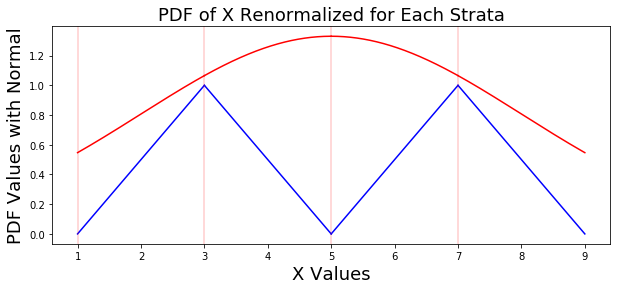

Number of Points Used in Each Strata: [198 132 252 420]


In [14]:
# Determine parameters for normal proposals and show on plot:
mu_vals = [3, 3, 7, 7]
sigma_vals = [1, 1, 1, 1]

# Define
mu_1 = 5
sigma_1 = 3
Mg_strat = lambda x: 10*gaussian(x, mu_1, sigma_1)

# Set variables and show plot
renorm = np.zeros(4)
xvals = np.zeros(4)
xouts = np.zeros(4)
sigmas = np.zeros(4)
fig = plt.figure(figsize=(10,4))
Umin = xmin
Umax = xmin + step
for reg in np.arange(0,Ns):
    # Set values
    xvals = x[(x>=Umin) & (x<=(Umax))]
    renorm[reg] = dx * np.sum(x_out[(x>=Umin) & (x<=(Umax))])
    xouts = x_out[(x>=Umin) & (x<=(Umax))] / renorm[reg]
    sigmas[reg] = np.std(h(xvals))
    
    # Add a plot
    plt.plot(xvals, xouts, 'b')
    plt.plot(xvals, Mg_strat(xvals), 'r')
    plt.axvline(Umin, 0, 1, color='r', alpha=0.2)
    
    # Get variability of target function in this region
    localmask = (Utry >= Umin) & (Utry < Umax)
    sigmas[reg] = np.std(Ytry[localmask])
    
    # Update the region
    Umin = Umin + step
    Umax = Umax + step
    
plt.xlabel('X Values')
plt.ylabel('PDF Values with Normal')
plt.title('PDF of X Renormalized for Each Strata')
plt.show()

nums = np.ceil(Ntry*renorm*sigmas/np.sum(renorm*sigmas)).astype(int)
print('Number of Points Used in Each Strata:', nums)

In [15]:
##################################################################
# Define a function for rejection sampling for stratefied region
def Perform_Rejection_Stratefied(Nsamp, x, x_out, Mg, lower, upper, mu, sigma):
    accepted = 0
    samples = np.zeros(Nsamp)
    count = 0
    
    # Sample from normal:
    X = truncnorm( (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma  )
    Xvals = np.round( X.rvs(Nsamp * 4), decimals = DEC)

    # Generation Loop
    while (accepted < Nsamp):
        # Get a proposal X value from truncated normal
        xproposal = Xvals[count]
        
        # Pick a uniform number on [0, 1)
        y = np.random.uniform(0,1)

        # Do the accept/reject comparison
        p = x_out[np.argmax(x==xproposal)]
        if y < p / Mg(xproposal):
            samples[accepted] = xproposal
            accepted+=1
        count += 1

    return(samples, count, accepted)
##################################################################

In [16]:
# Calculate number of points for sampling in each region
count_all = 0
accepted_all = 0
MUs = np.zeros(Ntrials)

# Loop over each trial
for k in np.arange(0, Ntrials):
    # Start in the first region with everything set to zero
    Umin = xmin
    Umax = step+xmin
    MUi = 0
    
    # Loop over each region
    for reg in np.arange(0, Ns): 
        # Set values
        xvals = x[(x>=Umin) & (x<=(Umax))]
        renorm[reg] = dx * np.sum(x_out[(x>=Umin) & (x<=(Umax))])
        xouts = x_out[(x>=Umin) & (x<=(Umax))] / renorm[reg]
    
        # Rejection sampling using number of points as proportional to size of region
        samples, count, accepted = Perform_Rejection_Stratefied(nums[reg], xvals, xouts, Mg_strat, Umin, Umax,
                                                                mu_1, sigma_1)
        
        # Change count and accepted
        count_all += count
        accepted_all += accepted
        
        #Add points in weighted fashion
        MUi = MUi + renorm[reg]*np.mean(h(samples))

        # Update the region
        Umin = Umin + step
        Umax = Umax + step
        
    # Add integral value
    MUs[k] = MUi
    
print('count:', count_all, 'accept:', accepted_all)
print('Percent Accept: %.3f' % (accepted_all/count_all))

count: 2018096 accept: 1002000
Percent Accept: 0.497


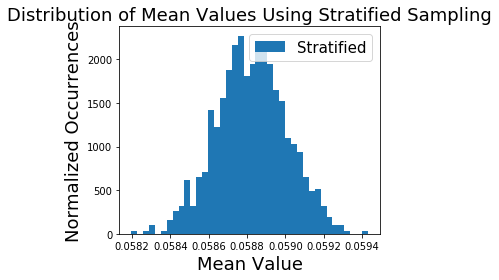

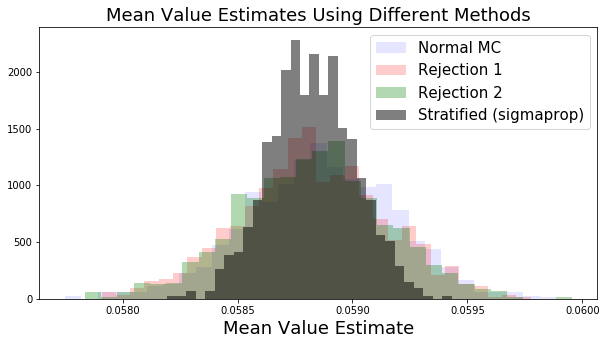

Mean Value Calculation: 0.0588

Variance for each method
Strategied: 3.3723e-08
Inverse: 1.0415e-07
Rejection 1: 1.0088e-07
Rejection 2: 1.0158e-07


In [17]:
# Plot stratified sampling method
plt.hist(MUs, bins=40, histtype='stepfilled', label=u'Stratified', normed=True)
plt.legend()
plt.title('Distribution of Mean Values Using Stratified Sampling')
plt.xlabel('Mean Value')
plt.ylabel('Normalized Occurrences')
plt.tight_layout()
plt.show()

# Plot all three methods at once:
plt.figure(figsize=(10,5))
plt.hist(h_out_1,30, histtype='stepfilled', color='b', label=u'Normal MC', alpha=0.1, normed=True)
plt.hist(h_out_2,30, histtype='stepfilled', color='r', label=u'Rejection 1', alpha=0.2, normed=True)
plt.hist(h_out_3, 30, histtype='stepfilled',color='g', label=u'Rejection 2', alpha=0.3, normed=True)
plt.hist(MUs, 30, histtype='stepfilled',color='k', label=u'Stratified (sigmaprop)', alpha=0.5, normed=True)
plt.xlabel('Mean Value Estimate')
plt.title('Mean Value Estimates Using Different Methods')
plt.legend()
plt.show()

print('Mean Value Calculation: %.4f\n' % np.mean(MUs))

# Computing Variance of each estimate of expectation:
print('Variance for each method\nStrategied: %.4e\nInverse: %.4e\nRejection 1: %.4e\nRejection 2: %.4e'
      % (np.var(MUs), np.var(h_out_1), np.var(h_out_2), np.var(h_out_3)))

We can see visually in the above plot that the stratified sampling greatly reduced the variance of our sampling distribution holding the number of trials and samples fixed from each model. I have also printed out the exact values of the variance for comparison.

## Problem 3: Linear Regression¶


In this problem, we create a linear regression class with a subclass that performs least squares fitting of a linear model.

### Part a) Create Linear Regression Class

In [18]:
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params[k]
    
    def set_params(self, **kwargs):
        for k,v in kwargs.items():
            self.params[k] = v
        
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()



In [19]:
class OLS(Regression):
    def __init__(self):
        Regression.__init__(self)
        
    def fit(self, X, y):
        # Add a column of one's to the X matrix
        n,m = X.shape
        X0 = np.ones((n,1))
        X = np.hstack((X,X0))
        
        # Fit a least squares linear regression
        inv_mat = np.linalg.pinv(X.T.dot(X))
        bhat =  inv_mat.dot(X.T).dot(y)
        
        # Set the parameters for self based on this fit
        self.set_params(intercept=bhat[m:m+1], coef=bhat[0:m])
        
    def predict(self, X):
        # Add a column of one's to the X matrix
        n,m = X.shape
        X0 = np.ones((n,1))
        X = np.hstack((X,X0))
        
        # Make predictions
        yhat = X.dot( np.hstack((lr.get_params('coef'), lr.get_params('intercept'))) )
        return(yhat)
        
    def score(self, X, y):
        ybar = np.mean(y)
        yhat = self.predict(X)
        SS_T = np.sum((y - ybar)**2)
        SS_E = np.sum((y - yhat)**2)
        score = 1 - SS_E / SS_T
        return(score)
    

R-Squared Score: 1.000:

Optimal Coefficients:
 [ 76.6568183   77.67682678  63.78807738  19.3299907   59.01638708
  53.13633737  28.77629958  10.01888939   9.25346811  59.55220395]

My Calculated Coefficients:
 [ 77.20719705  76.51004831  62.97865316  18.4436452   58.50019885
  53.25126559  28.29088241   9.33333359  10.29584457  59.1606719 ]


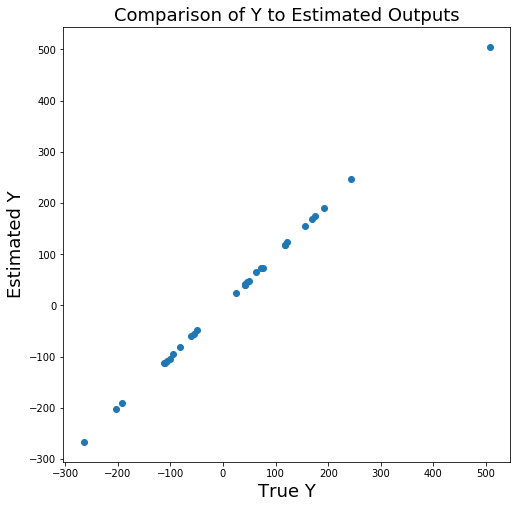

In [20]:
from sklearn.datasets import make_regression
np.random.seed(99)
X, y, coef = make_regression(30,10, 10, bias=1, noise=2, coef=True)

# Run least squares regression
lr = OLS()
lr.fit(X,y)
B1 = lr.get_params('coef')
yhat = lr.predict(X)
R2 = lr.score(X,y)
print('R-Squared Score: %.3f:' % R2)

# Compare coefficients
print('\nOptimal Coefficients:\n', coef)
print('\nMy Calculated Coefficients:\n', B1)


fig = plt.figure(figsize=(8,8))
plt.plot(y, yhat,'o')
plt.title('Comparison of Y to Estimated Outputs')
plt.xlabel('True Y')
plt.ylabel('Estimated Y')
plt.show()

In the above figure, we have shown that our proposed least squares fit matches the data with a high correlation coefficient. This does not always indicate that this is a good model for the phenomenon, but it does indicate that the model fits well with the data provided.